In [125]:
%load_ext autoreload
%autoreload 2

import pickle
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

# Funciones
# -----------------------------------------------------------------------
import sys
sys.path.append('../../')
import src.funciones as f
import src.soporte_prep as spp
import src.soporte_encoding as se
import src.soporte_logistica as sl


# Para realizar la regresión lineal y la evaluación del modelo
# -----------------------------------------------------------------------
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor

from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [126]:
df = pd.read_csv('../../Datos/Datos_Modelo_1/Modelo_1_CL_1.csv', index_col=0) # importo mi modelo más importante
df.head()

,Sales,Shipping Cost,Ship Mode_First Class,Ship Mode_Same Day,Ship Mode_Second Class,Ship Mode_Standard Class,Segment_Consumer,Segment_Corporate,Segment_Home Office,Order Priority_Critical,Order Priority_High,Order Priority_Low,Order Priority_Medium,Market,Category,Sub-Category,Discount_Category,Quantity_Group
0,2309.650,46.172483,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,184.746760,406.920476,221.649278,238.638826,417.991151
1,3709.395,45.676969,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,280.765352,376.156674,395.652475,238.638826,417.991151
2,2832.960,44.650548,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,153.708483,400.579782,601.838328,235.582284,418.867386
3,5244.840,43.421236,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,279.150012,372.352737,723.616049,235.582284,418.867386
4,4164.050,41.833998,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,183.527906,109.485297,90.500003,235.582284,173.453124


In [127]:
x= df.drop(columns='Sales')
y = df[['Sales']]

In [128]:
def metricas(y_train, y_train_pred, y_test, y_test_pred):
    metricas = {
    'train': {
        'r2_score': r2_score(y_train, y_train_pred),
        'MAE': mean_absolute_error(y_train, y_train_pred),
        'MSE': mean_squared_error(y_train, y_train_pred),
        'RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred))
    },
    'test': {
        'r2_score': r2_score(y_test, y_test_pred),
        'MAE': mean_absolute_error(y_test, y_test_pred),
        'MSE': mean_squared_error(y_test, y_test_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred))

    }
    }

    return pd.DataFrame(metricas).T

In [129]:
x_train, x_test, y_train, y_test = train_test_split(x,y, train_size=0.7, random_state=42)

In [130]:
modelo_lineal = LinearRegression()
modelo_lineal.fit(x_train, y_train) # aprendizaje

LinearRegression()

In [131]:
y_train_pred = modelo_lineal.predict(x_train)
y_train_pred[:3]

array([[ 50.29760783],
       [-55.67662563],
       [ 74.3570235 ]])

In [132]:
y_test_pred = modelo_lineal.predict(x_test) # predicciones, con xtest porque xtest son sus parametros. ytest son las respuestas con las que comparemos
y_test_pred[:3]

array([[122.90129487],
       [ 11.44206995],
       [472.94066249]])

In [133]:
y_test = np.array(y_test).ravel()
y_test_pred = np.array(y_test_pred).ravel()

In [134]:
metricas(y_train,y_train_pred,y_test,y_test_pred)

,r2_score,MAE,MSE,RMSE
train,0.740838,98.753396,37302.345846,193.138152
test,0.699944,100.000844,43775.999567,209.227148


No existe una diferencia marcada entre ambos conjuntos. No cabe decir que existe overfitting o underfitting. A diferencia del Cluster_0, este grupo tiene buenas predicciones con las mismas variables predictoras. Las diferencias en r2 no son muy distantes, tampoco entre el RMSE.

Text(0, 0.5, 'Predicciones (y_test_pred)')

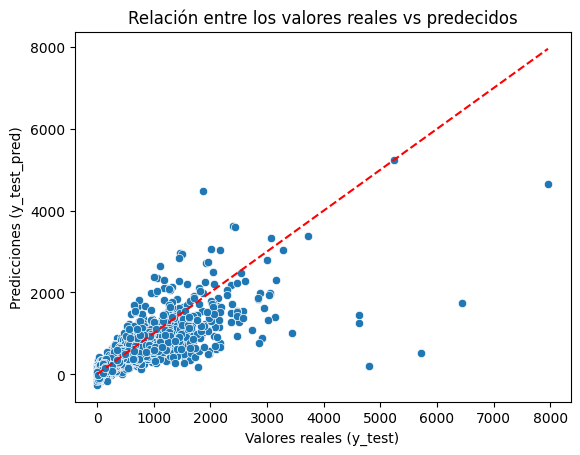

In [135]:
sns.scatterplot(x=y_test, y=y_test_pred)
sns.lineplot(x = [min(y_test), max(y_test)], y = [min(y_test), max(y_test)], markersize = 1, color = "red", linestyle = "--")

plt.title('Relación entre los valores reales vs predecidos')
plt.xlabel('Valores reales (y_test)')
plt.ylabel('Predicciones (y_test_pred)')

## Decision Tree

In [136]:
params_arbol = {
    'max_depth': [4, 7,10,14],
    'min_samples_split': [10, 50, 100, 200],
    'min_samples_leaf': [10, 15, 20, 30],
    'max_leaf_nodes': [6, 8, 10, 20, 30]
}

In [137]:
params_arbol_2 = {
    'max_depth': [6, 7,8,9],
    'min_samples_split': [40,50,60],
    'min_samples_leaf': [18, 20,21],
    'max_leaf_nodes': [25,28,30,32,35]
}

In [138]:
params_arbol_3 = {
    'max_depth': [6, 7,8,9],
    'min_samples_split': [15, 50, 100],
    'min_samples_leaf': [20,30,40],
    'max_leaf_nodes': [32,35,40,42]
}

In [139]:
params_arbol_4 = {
    'max_depth': [3,4,5,6,7],
    'min_samples_split': [15, 50, 100],
    'min_samples_leaf': [20,30,40],
    'max_leaf_nodes': [32,35,40,42]
}

In [140]:
params_arbol_5 = {
    'max_depth': [5],
    'min_samples_split': [30,35,40,45,50],
    'min_samples_leaf': [17,20,22],
    'max_leaf_nodes': [38,40,42]
}

In [141]:
params_arbol_6 = {
    'max_depth': [6,7],
    'min_samples_split': [5,7,10],
    'min_samples_leaf': [5,7,10],
    'max_leaf_nodes': [30,32,35,40,42,50,60,100]
}

In [142]:
grid_search_arbol = GridSearchCV(DecisionTreeRegressor(),
                                 param_grid=params_arbol_6,
                                 cv = 5,
                                 scoring= 'neg_mean_squared_error',
                                 n_jobs=-1)
grid_search_arbol.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [6, 7],
                         'max_leaf_nodes': [30, 32, 35, 40, 42, 50, 60, 100],
                         'min_samples_leaf': [5, 7, 10],
                         'min_samples_split': [5, 7, 10]},
             scoring='neg_mean_squared_error')

In [143]:
modelo_final_arbol = grid_search_arbol.best_estimator_

In [144]:
modelo_final_arbol

DecisionTreeRegressor(max_depth=7, max_leaf_nodes=100, min_samples_leaf=7,
                      min_samples_split=5)

In [145]:
y_test_pred_final = modelo_final_arbol.predict(x_test)
y_train_pred_final = modelo_final_arbol.predict(x_train)

In [146]:
df_metricas_arbol = metricas(y_train, y_train_pred_final, y_test, y_test_pred_final)

In [147]:
df_metricas_arbol

,r2_score,MAE,MSE,RMSE
train,0.871726,62.162075,18463.050658,135.878809
test,0.773091,68.317147,33104.414512,181.946186


Estas métricas no son malas, sorprende que el modelo funcione mejor para este Cluster. Existe cierta diferencia entre el r2, pero no parece ser enorme para decir que existe overfitting.

In [54]:
df_resultados_arbol = pd.DataFrame(grid_search_arbol.cv_results_).sort_values(by = 'rank_test_score', ascending=True)
df_resultados_arbol.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_leaf_nodes,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
81,0.099842,0.034415,0.012768,0.014249,7,35,18,40,"{'max_depth': 7, 'max_leaf_nodes': 35, 'min_sa...",-31831.179597,-30574.371979,-23512.077924,-26748.429737,-20452.489126,-26623.709672,4254.579790,1
126,0.096721,0.020158,0.006016,0.000953,8,35,18,40,"{'max_depth': 8, 'max_leaf_nodes': 35, 'min_sa...",-31831.179597,-30574.371979,-23512.077924,-26748.429737,-20452.489126,-26623.709672,4254.579790,2
171,0.117056,0.028366,0.008759,0.003438,9,35,18,40,"{'max_depth': 9, 'max_leaf_nodes': 35, 'min_sa...",-31831.179597,-30574.371979,-23512.077924,-26748.429737,-20452.489126,-26623.709672,4254.579790,2
174,0.106483,0.033589,0.005353,0.001403,9,35,20,40,"{'max_depth': 9, 'max_leaf_nodes': 35, 'min_sa...",-31831.179597,-31138.552393,-23512.077924,-26777.295996,-20452.489126,-26742.319007,4363.966335,4
129,0.094064,0.014376,0.007835,0.001470,8,35,20,40,"{'max_depth': 8, 'max_leaf_nodes': 35, 'min_sa...",-31831.179597,-31138.552393,-23512.077924,-26777.295996,-20452.489126,-26742.319007,4363.966335,4
84,0.107240,0.035886,0.006153,0.001302,7,35,20,40,"{'max_depth': 7, 'max_leaf_nodes': 35, 'min_sa...",-31831.179597,-31138.552393,-23512.077924,-26777.295996,-20452.489126,-26742.319007,4363.966335,4
36,0.119410,0.043285,0.010060,0.008059,6,35,18,40,"{'max_depth': 6, 'max_leaf_nodes': 35, 'min_sa...",-32341.302415,-30978.903784,-23377.317845,-26304.581441,-20795.045693,-26759.430235,4385.902613,7
165,0.099836,0.027268,0.009062,0.004486,9,32,20,40,"{'max_depth': 9, 'max_leaf_nodes': 32, 'min_sa...",-31697.572260,-31226.689861,-23594.767611,-26768.975182,-20736.267078,-26804.854399,4257.346909,8
75,0.106561,0.023181,0.011753,0.011250,7,32,20,40,"{'max_depth': 7, 'max_leaf_nodes': 32, 'min_sa...",-31697.572260,-31226.689861,-23594.767611,-26768.975182,-20736.267078,-26804.854399,4257.346909,8
120,0.077623,0.016069,0.004712,0.000990,8,32,20,40,"{'max_depth': 8, 'max_leaf_nodes': 32, 'min_sa...",-31697.572260,-31226.689861,-23594.767611,-26768.975182,-20736.267078,-26804.854399,4257.346909,8


In [55]:
df_resultados_arbol_filtrado = df_resultados_arbol.filter(like='param').drop(columns='params')
df_resultados_arbol_filtrado['MSE'] = df_resultados_arbol['mean_test_score']
df_resultados_arbol_filtrado

,param_max_depth,param_max_leaf_nodes,param_min_samples_leaf,param_min_samples_split,MSE
81,7,35,18,40,-26623.709672
126,8,35,18,40,-26623.709672
171,9,35,18,40,-26623.709672
174,9,35,20,40,-26742.319007
129,8,35,20,40,-26742.319007
...,...,...,...,...,...
97,8,25,21,50,-28157.730936
6,6,25,21,40,-28455.455876
51,7,25,21,40,-28455.455876
141,9,25,21,40,-28455.455876


In [26]:
df_rmse_prof = np.sqrt(df_resultados_arbol_filtrado.groupby('param_max_depth')['MSE'].mean().abs()).reset_index()

In [27]:
df_rmse_prof

,param_max_depth,MSE
0,4,192.856313
1,7,189.093651
2,10,189.093651
3,14,189.093651


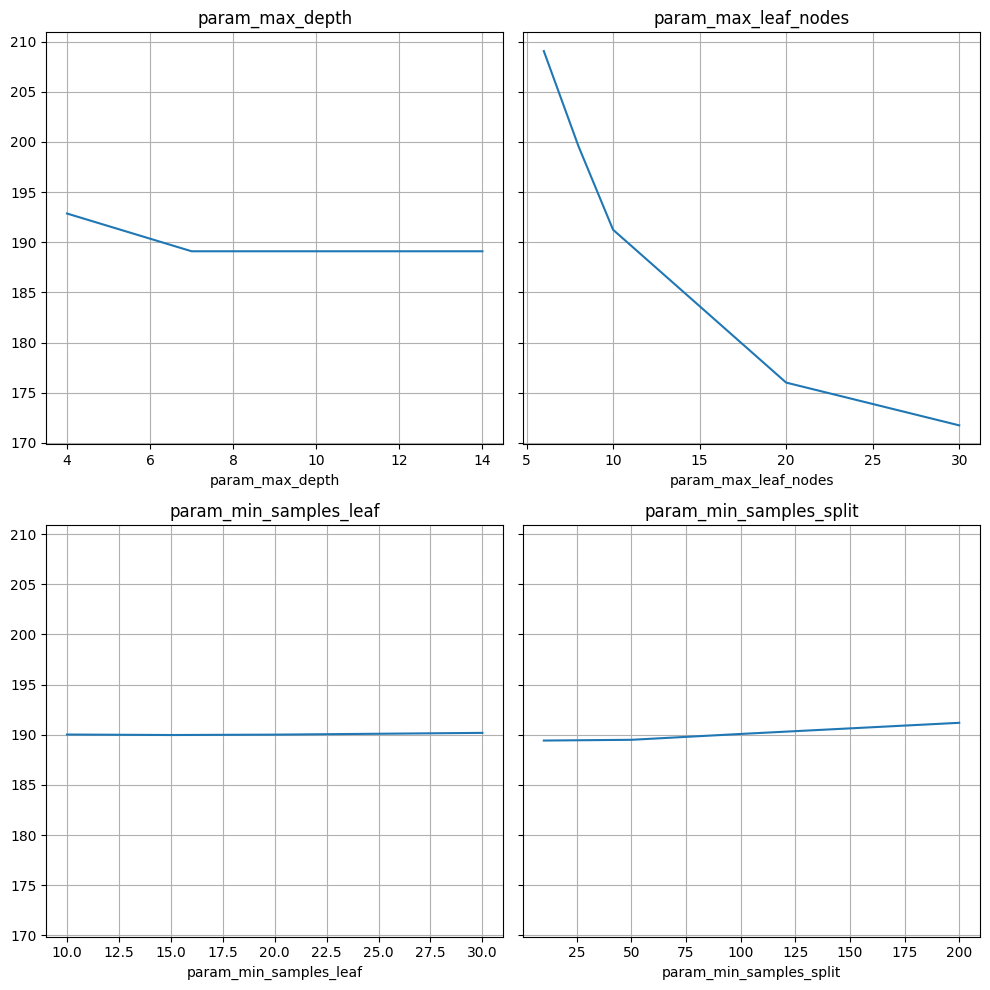

In [28]:
# df_rmse_prof = np.sqrt(df_resultados_arbol_filtrado.groupby("param_max_depth")["MSE"].mean().abs())
# df_rmse_prof = pd.DataFrame(df_rmse_prof).reset_index()

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 10), sharey=True)
axes = axes.flat

for indice, column in enumerate(df_resultados_arbol_filtrado.columns[:-1]):
    # Asegurarse de no exceder el número de subgráficos
    if indice >= len(axes):
        break

    df_rmse_col = np.sqrt(df_resultados_arbol_filtrado.groupby(column)["MSE"].mean().abs())

    sns.lineplot(x=df_rmse_col.index, y=df_rmse_col.values, ax=axes[indice])
    axes[indice].grid()
    axes[indice].set_title(column)

plt.tight_layout()
plt.show() 

In [29]:
df_importancia = pd.DataFrame(modelo_final_arbol.feature_importances_,columns = ['Importancia'], index=x.columns).sort_values(by='Importancia', ascending=False)

<Axes: xlabel='Importancia', ylabel='None'>

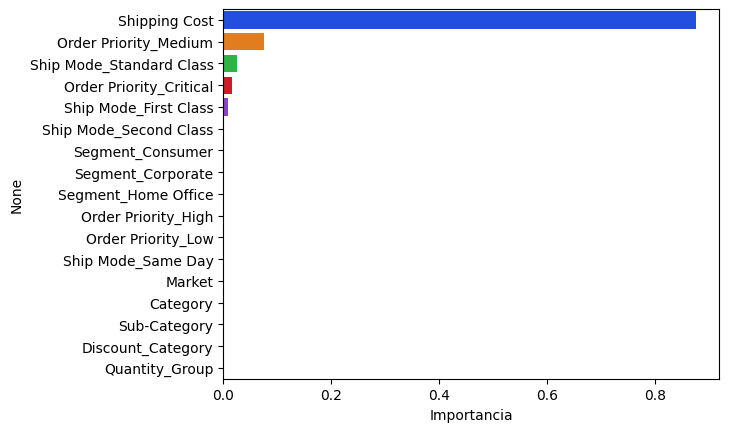

In [30]:
sns.barplot(x='Importancia', y=df_importancia.index ,data=df_importancia, palette='bright')

## Random Forest

In [ ]:
params_rrf = {
    'n_estimators': [100, 250, 300],
    'max_features': [4,6,8],
    'max_depth': [7,8],
    'min_samples_split': [5,7],
    'min_samples_leaf': [5,7,8], 
    'max_leaf_nodes': [100]
}

modelo_rrf = RandomForestRegressor(random_state=42, bootstrap=True,n_jobs=-1) # por este método nos pide un array

randonmized_rrf = RandomizedSearchCV(modelo_rrf, # solo hace las iteraciones que le digo
                              params_rrf,
                              cv = 5,
                              scoring='neg_mean_squared_error',
                              n_jobs=-1,
                              random_state=50, #semilla
                              n_iter=10,
                              verbose=10)

randonmized_rrf.fit(x_train, y_train['Sales'].values) # array de una dim
modelo_final_rrf = randonmized_rrf.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [149]:
modelo_final_rrf

RandomForestRegressor(max_depth=7, max_features=8, max_leaf_nodes=100,
                      min_samples_leaf=7, min_samples_split=7, n_estimators=300,
                      n_jobs=-1, random_state=42)

In [150]:
y_pred_test_rrf = modelo_final_rrf.predict(x_test)
y_pred_train_rrf = modelo_final_rrf.predict(x_train)
df_metricas_rrf = metricas(y_train, y_pred_train_rrf, y_test, y_pred_test_rrf)
df_metricas_rrf

,r2_score,MAE,MSE,RMSE
train,0.873607,60.641952,18192.219900,134.878538
test,0.789006,65.978812,30782.515408,175.449467


### Random Distinto

In [151]:
params_rf = {
    'n_estimators': [250,300],
    'max_features': [6,8],
    'max_depth': [7],
    'min_samples_split': [7,8],
    'min_samples_leaf': [7,8], 
    'max_leaf_nodes': [100]
}

modelo_rf = RandomForestRegressor(random_state=42, bootstrap=True) # por este método nos pide un array

grid_search_rf = GridSearchCV(modelo_rf,
                              params_rf,
                              cv = 3,
                              scoring='neg_mean_squared_error',
                              n_jobs=-1,
                              )

grid_search_rf.fit(x_train, y_train['Sales'].values) # array de una dim
modelo_final_rf = grid_search_rf.best_estimator_

In [152]:
modelo_final_rf

RandomForestRegressor(max_depth=7, max_features=8, max_leaf_nodes=100,
                      min_samples_leaf=7, min_samples_split=7, n_estimators=250,
                      random_state=42)

In [153]:
y_pred_test_rf = modelo_final_rf.predict(x_test)
y_pred_train_rf = modelo_final_rf.predict(x_train)
df_metricas_rf = metricas(y_train, y_pred_train_rf, y_test, y_pred_test_rf)
df_metricas_rf

,r2_score,MAE,MSE,RMSE
train,0.873849,60.616526,18157.429076,134.749505
test,0.789136,65.925966,30763.517606,175.395318


## Gradient Booster

In [154]:
params_gb = {
    'n_estimators': [200,300],
    'learning_rate': [0.01,0.1,0.2],
    'max_depth': [7,9],
    'min_samples_split': [6,7],
    'min_samples_leaf': [7,8,10], 
}

modelo_gb = GradientBoostingRegressor(random_state=42) # por este método nos pide un array

grid_search_gb = GridSearchCV(modelo_gb,
                              params_gb,
                              cv = 5,
                              scoring='neg_mean_squared_error',
                              n_jobs=-1)

grid_search_gb.fit(x_train, y_train['Sales'].values) # array de una dim
modelo_final_gb = grid_search_gb.best_estimator_

In [155]:
modelo_final_gb

GradientBoostingRegressor(learning_rate=0.01, max_depth=7, min_samples_leaf=7,
                          min_samples_split=6, n_estimators=300,
                          random_state=42)

In [156]:
y_pred_test_gb = modelo_final_gb.predict(x_test)
y_pred_train_gb = modelo_final_gb.predict(x_train)
df_metricas_gb = metricas(y_train, y_pred_train_gb, y_test, y_pred_test_gb)
df_metricas_gb

,r2_score,MAE,MSE,RMSE
train,0.909919,54.077782,12965.811717,113.867518
test,0.792842,64.555370,30222.942333,173.847469


De todos los modelos, este pudiera ser el mejor para este cluster_1. Sin embargo, se genera un poco de overfitting.

## XGB

In [157]:
params_xgb = {
    'n_estimators': [300],
    'learning_rate': [0.01, 0.05,0.1,0.2],
    'max_depth': [7,9],
    'min_child_weight': [7,8,10],
    'subsample': [0.8,1.0], 
    'colsample_bytree': [0.25,0.7,0.8]
}

modelo_xgb = XGBRegressor(random_state=42) # por este método nos pide un array

grid_search_xgb = GridSearchCV(modelo_xgb,
                              params_xgb,
                              cv = 3,
                              scoring='neg_mean_squared_error',
                              n_jobs=-1)

grid_search_xgb.fit(x_train, y_train['Sales'].values) # array de una dim
modelo_final_xgb = grid_search_xgb.best_estimator_

In [158]:
modelo_final_xgb

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=10, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [159]:
y_pred_test_xgb = modelo_final_xgb.predict(x_test)
y_pred_train_xgb = modelo_final_xgb.predict(x_train)
df_metricas_xgb = metricas(y_train, y_pred_train_xgb, y_test, y_pred_test_xgb)
df_metricas_xgb

,r2_score,MAE,MSE,RMSE
train,0.931592,48.012075,9846.304450,99.228547
test,0.794382,63.136457,29998.267212,173.200079


Es apreciable el overfitting en este caso, no sería el modelo a elegir.